## Problem 1: Develop a method to classify images from healthy donors and leukemia patients

Dataset preprocessing steps are performed at `dataset_preprocessing.py` script.

We have unzipped data, combined *light* and *dark* images, removed corrupted ones, splitted in smaller patches and convert to ImageNet dataset form to feed to our classifier.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import ncessary packages

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

In [4]:
path = Path("/storage_2/CITRE/CITRE_classification")

In [5]:
path.ls()

[PosixPath('/storage_2/CITRE/CITRE_classification/test'),
 PosixPath('/storage_2/CITRE/CITRE_classification/valid'),
 PosixPath('/storage_2/CITRE/CITRE_classification/train')]

In [6]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

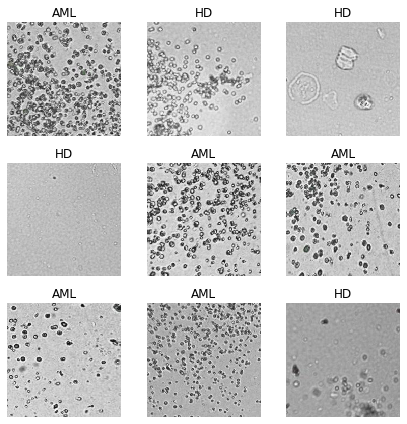

In [7]:
data.show_batch(rows=3, figsize=(6, 6))

In [8]:
print(data.classes)
len(data.classes), data.c

['AML', 'HD']


(2, 2)

## Training: resnet34

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.027087,0.005072,0.001741,00:38
1,0.010186,0.003527,0.001583,00:35
2,0.007298,0.001526,0.000633,00:36
3,0.005296,0.000506,0.000000,00:36


In [12]:
learn.save('stage-1')

## Results

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

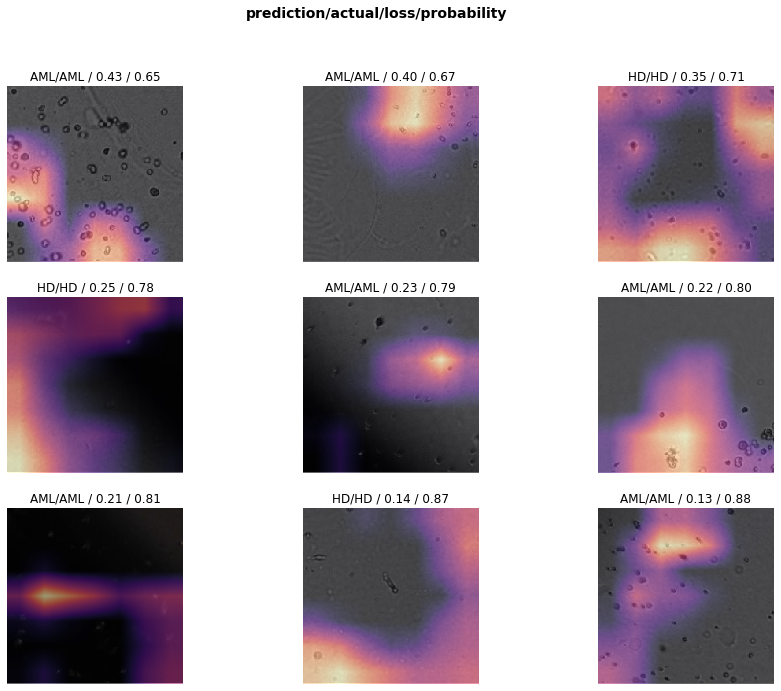

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

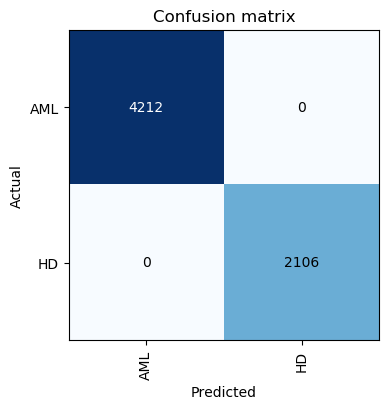

In [15]:
interp.plot_confusion_matrix(figsize=(4, 4), dpi=100)

## Let's build confusion matrix on test data

In [17]:
data_test = ImageDataBunch.from_folder(path, train="train", valid="test", ds_tfms=get_transforms(),
                                       size=224, bs=bs).normalize(imagenet_stats)

In [18]:
learn_test = cnn_learner(data_test, models.resnet34, metrics=error_rate)

In [20]:
learn_test.load('stage-1');

In [22]:
interp_test = ClassificationInterpretation.from_learner(learn_test)

losses_test,idxs_test = interp.top_losses()

len(data.valid_ds)==len(losses_test)==len(idxs_test)

True

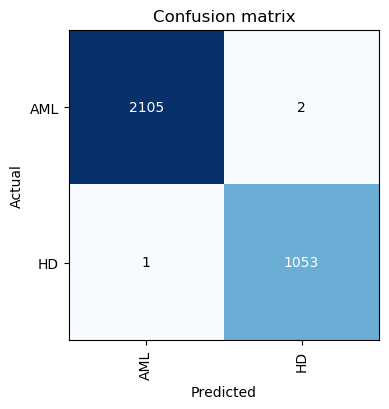

In [23]:
interp_test.plot_confusion_matrix(figsize=(4, 4), dpi=100)

## Unfreezing, fine-tuning, and learning rates

In [24]:
learn.load('stage-1');

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.004945,0.000421,0.000158,00:48
1,0.003239,0.000535,0.000317,00:49


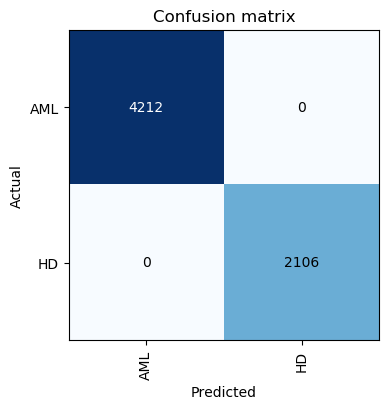

In [28]:
interp.plot_confusion_matrix(figsize=(4, 4), dpi=100)

In [29]:
learn.save('stage-2')

In [30]:
# build confusion matrix on test data
data_test = ImageDataBunch.from_folder(path, train="train", valid="test", ds_tfms=get_transforms(),
                                       size=224, bs=bs).normalize(imagenet_stats)

In [31]:
learn_test = cnn_learner(data_test, models.resnet34, metrics=error_rate)

In [32]:
learn_test.load('stage-2');

In [33]:
interp_test = ClassificationInterpretation.from_learner(learn_test)

losses_test,idxs_test = interp.top_losses()

len(data.valid_ds)==len(losses_test)==len(idxs_test)

True

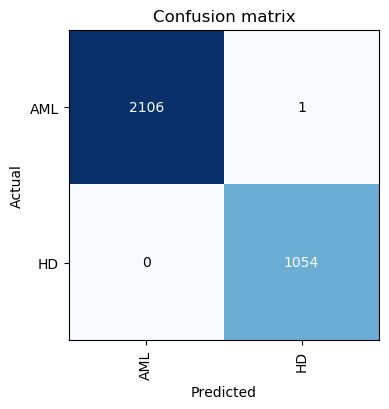

In [34]:
interp_test.plot_confusion_matrix(figsize=(4, 4), dpi=100)